## Transfer Learning

To learn more about Transfer Learning read [this](https://www.tensorflow.org/tutorials/images/transfer_learning)

In [1]:
import os

DATA_DIR = "/Users/rakesh.karanth/DeepLearning/TensorFlowInPractice/dataset/cats_or_dogs/"
TRAINING_DATA_DIR = os.path.join(DATA_DIR, "train")
TEST_DATA_DIR = os.path.join(DATA_DIR, "test")

## Prepare training and validation data

In [2]:
import pandas as pd

string_labels = []   # To store image labels as string ("cat" or "dog")
integer_labels = []  # To store image labels as integer ("dog" == 1 and "cat" == 0)

image_names = os.listdir(TRAINING_DATA_DIR)
for image_name in image_names:
    animal = image_name.split('.')[0]
    if animal == "dog":
        string_labels.append("dog")
        integer_labels.append(1)
    else:
        string_labels.append("cat")
        integer_labels.append(0)

df = pd.DataFrame({
    'image_name' : image_names,
    'string_label' : string_labels,
    'integer_label' : integer_labels
})

### Get input examples count

In [3]:
df.count()

image_name       25000
string_label     25000
integer_label    25000
dtype: int64

### Look at the input dataframe head and tail

In [4]:
df.head()

,image_name,string_label,integer_label
0,dog.8011.jpg,dog,1
1,cat.5077.jpg,cat,0
2,dog.7322.jpg,dog,1
3,cat.2718.jpg,cat,0
4,cat.10151.jpg,cat,0


In [5]:
df.tail()

,image_name,string_label,integer_label
24995,dog.8008.jpg,dog,1
24996,dog.1992.jpg,dog,1
24997,dog.12412.jpg,dog,1
24998,cat.2701.jpg,cat,0
24999,cat.10148.jpg,cat,0


### Look at the number of cats vs dogs in the input data

In [6]:
df["string_label"].value_counts()

dog    12500
cat    12500
Name: string_label, dtype: int64

### Generate training and validation data from the input

Use validation data if you need to tune model parameters

In [7]:
from sklearn.model_selection import train_test_split

# Use a psuedo random number generator as we always want to get the same examples for training and validation
# Use stratify and use the string_label column to influence the data split
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["string_label"])

# Reset row indices. Do not add the old index as a column in the dataframe
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

# Get the training image names (Used later for visualization)
train_image_names = train_df["image_name"].tolist()

### Get training examples count

In [8]:
train_df.count()

image_name       20000
string_label     20000
integer_label    20000
dtype: int64

### Look at the train dataframe head and tail

In [9]:
train_df.head()

,image_name,string_label,integer_label
0,dog.62.jpg,dog,1
1,cat.857.jpg,cat,0
2,dog.7071.jpg,dog,1
3,dog.9084.jpg,dog,1
4,dog.8257.jpg,dog,1


In [10]:
train_df.tail()

,image_name,string_label,integer_label
19995,dog.8233.jpg,dog,1
19996,dog.4337.jpg,dog,1
19997,cat.9733.jpg,cat,0
19998,cat.8866.jpg,cat,0
19999,dog.6023.jpg,dog,1


### Look at the number of cats vs dogs in the training data

In [11]:
train_df["string_label"].value_counts()

cat    10000
dog    10000
Name: string_label, dtype: int64

### Get validation examples count

In [12]:
validate_df.count()

image_name       5000
string_label     5000
integer_label    5000
dtype: int64

### Look at the validation dataframe head and tail

In [13]:
validate_df.head()

,image_name,string_label,integer_label
0,dog.4613.jpg,dog,1
1,dog.4664.jpg,dog,1
2,cat.3521.jpg,cat,0
3,cat.3116.jpg,cat,0
4,dog.7520.jpg,dog,1


In [14]:
validate_df.tail()

,image_name,string_label,integer_label
4995,dog.1144.jpg,dog,1
4996,cat.6102.jpg,cat,0
4997,cat.9445.jpg,cat,0
4998,dog.10673.jpg,dog,1
4999,dog.3593.jpg,dog,1


### Look at the number of cats vs dogs in the validation data

In [15]:
validate_df["string_label"].value_counts()

dog    2500
cat    2500
Name: string_label, dtype: int64

## Visualize a few training images

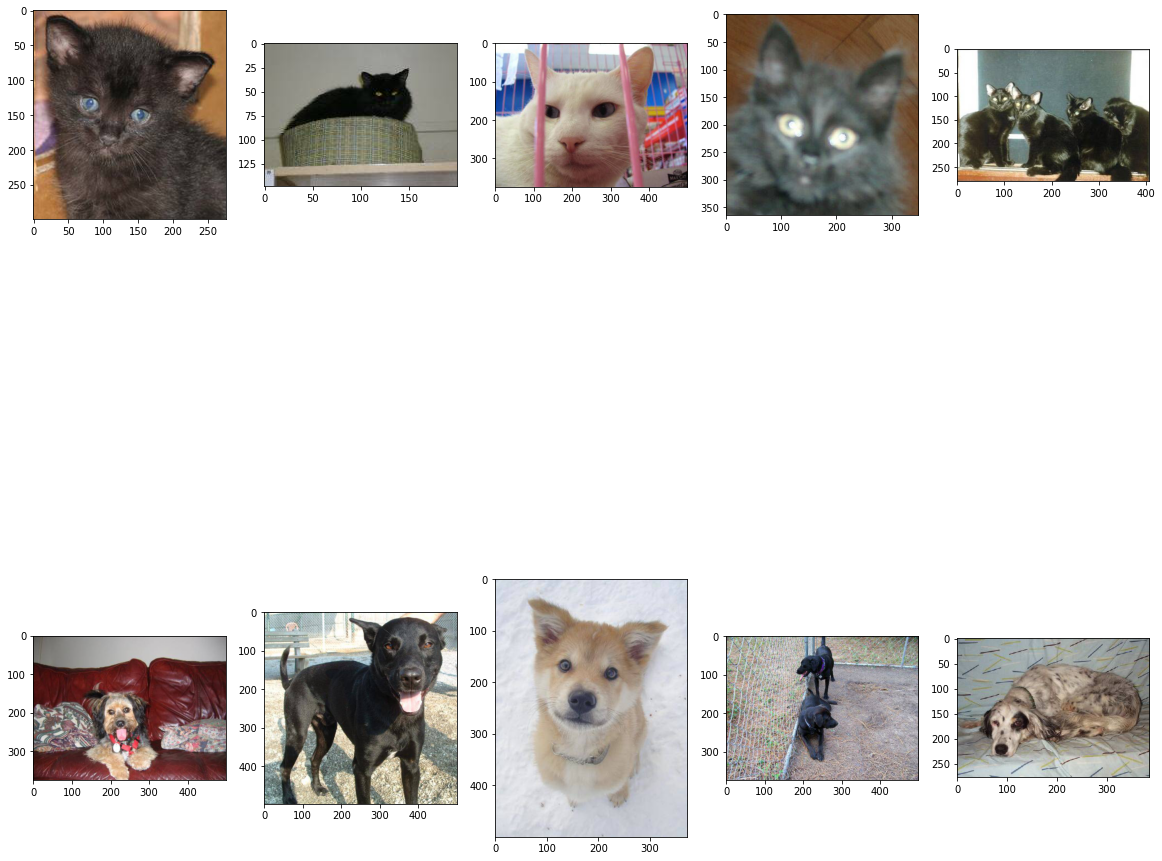

In [16]:
import random
import matplotlib.pyplot as plt

# Extract 5 random images for cats and dogs
cat_images = []
dog_images = []
while len(cat_images) != 5:
    image_name = random.choice(train_image_names)
    animal = image_name.split('.')[0]
    if animal == "cat":
        cat_images.append(os.path.join(TRAINING_DATA_DIR, image_name))

while len(dog_images) != 5:
    image_name = random.choice(train_image_names)
    animal = image_name.split('.')[0]
    if animal == 'dog':
        dog_images.append(os.path.join(TRAINING_DATA_DIR, image_name))

# One row for cats and the other for dogs
num_rows = 2
num_images = 5

figure, axes = plt.subplots(nrows=num_rows, ncols=num_images, figsize=(20,20))
for row, r_idx in zip(axes, range(0, 2)):
    # First row is for cats and second is for dogs
    if r_idx == 0:
        images_to_plot = cat_images
    else:
        images_to_plot = dog_images
    
    for column, image in zip(row, images_to_plot):
        image_data = plt.imread(image)
        column.imshow(image_data)

plt.show()

## Data Preprocessing

Set up data generators that will read pictures in the source folder, convert them to float32 tensors, and feed them (along with the labels) to our Neural Network. We need to have one generator for the training data and one for the validation data.

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# For the training data try out image augmentation
train_data_image_gen = ImageDataGenerator(
    rescale=1.0/255,        # Rescale images by multiplying each value in the tensor by (1.0/255)
    rotation_range=40,      # Rotate image by random amounts between [0-40]
    width_shift_range=0.2,  # Randomly move subjects by 20% horizontally within the image
    height_shift_range=0.2, # Randomly move subjects by 20% vertically within the image
    shear_range=0.2,        # Apply shear mapping of 20% 
    zoom_range=0.2,         # Apply 20% zoom on the input image
    horizontal_flip=True,   # Mirror image behavior (Left hand becomes right hand and vice versa)
    fill_mode="nearest"     # Fill lost pixels by looking at the nearest neighbors
)

# No need of any image augmentation for the validation data
validation_data_image_gen = ImageDataGenerator(rescale=1.0/255)

# Get the actual training data generator
train_generator = train_data_image_gen.flow_from_dataframe(
    train_df,                       # The dataframe containing filenames relative to "directory"
    directory = TRAINING_DATA_DIR,  # The directory in which the training images can be found
    x_col = "image_name",           # The column within the dataframe which is to be treated as the input
    y_col = "string_label",         # The column within the dataframe which is to be treated as the output
    target_size = (150, 150),       # Each image should be of size (150, 150)
    class_mode = "binary",          # We are dealing with a binary classification problem
    batch_size = 128                # Load images in batches of size 128
)

# Get the actual validation data generator
validation_generator = validation_data_image_gen.flow_from_dataframe(
    validate_df,                    # The dataframe containing filenames relative to "directory"
    directory = TRAINING_DATA_DIR,  # The directory in which the validation images can be found
    x_col = "image_name",           # The column within the dataframe which is to be treated as the input
    y_col = "string_label",         # The column within the dataframe which is to be treated as the output
    target_size = (150, 150),       # Each image should be of size (150, 150)
    class_mode = "binary",          # We are dealing with a binary classification problem
    batch_size = 32                 # Load images in batches of size 32
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


### See how the data generator works with a cat image

     image_name string_label  integer_label
0  cat.7161.jpg          cat              0

Found 1 validated image filenames belonging to 1 classes.


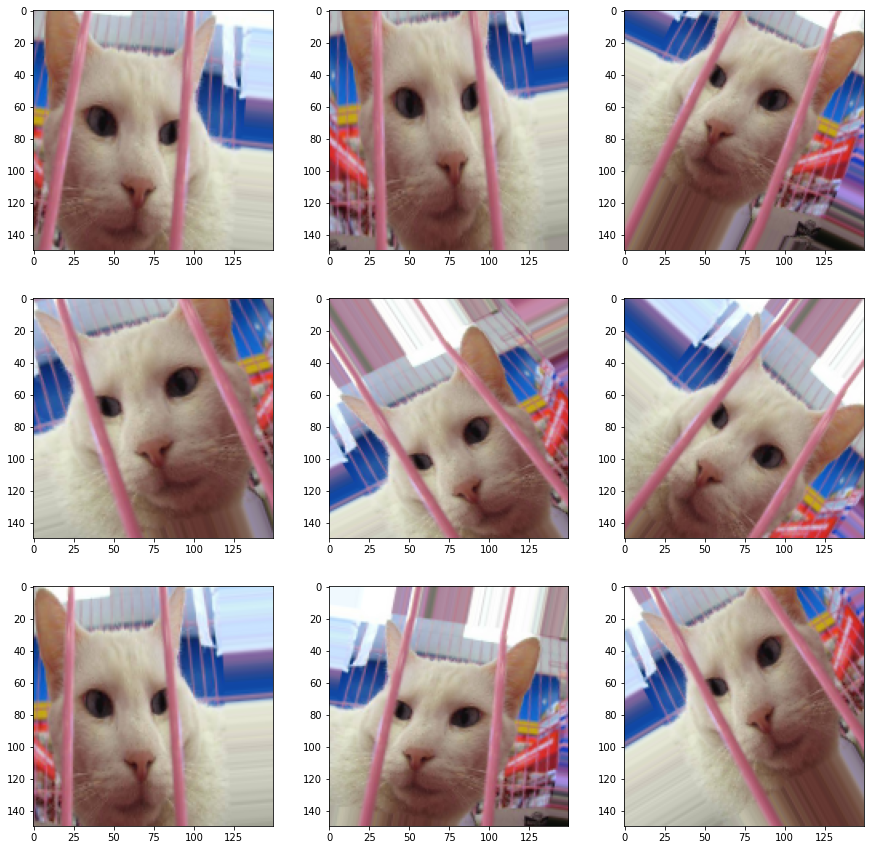

In [18]:
cat_image_name = os.path.basename(cat_images[2])
cat_example_df = train_df[train_df["image_name"] == cat_image_name]
cat_example_df = cat_example_df.reset_index(drop=True)
print (cat_example_df)
print ()

# If we set the class_mode to "binary" we see the following error - If class_mode="binary" there must be 2 classes. Found 1 classes.
sample_cat_generator = train_data_image_gen.flow_from_dataframe(
    cat_example_df,
    directory = TRAINING_DATA_DIR,
    x_col = "image_name",
    y_col = "string_label",
    target_size = (150, 150),
    class_mode = "categorical"
)

# Let us look at 9 image augmentations in total
figure, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,15))
for row in axes:
    for column in row:
        cat_image_data = sample_cat_generator.next()
        cat_image_data = cat_image_data[0]
        cat_image_data = cat_image_data.reshape(cat_image_data.shape[1],
                                                cat_image_data.shape[2],
                                                cat_image_data.shape[3])
        column.imshow(cat_image_data)

plt.show()

### See how the data generator works with a dog image

     image_name string_label  integer_label
0  dog.3047.jpg          dog              1

Found 1 validated image filenames belonging to 1 classes.


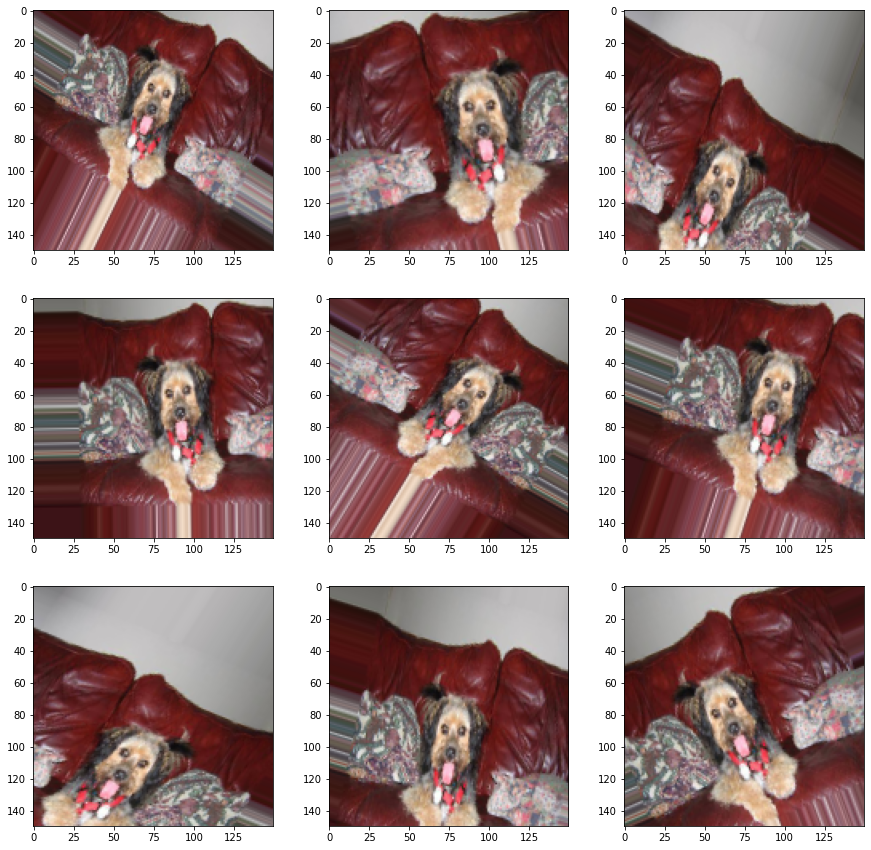

In [19]:
dog_image_name = os.path.basename(dog_images[0])
dog_example_df = train_df[train_df["image_name"] == dog_image_name]
dog_example_df = dog_example_df.reset_index(drop=True)
print (dog_example_df)
print ()

# If we set the class_mode to "binary" we see the following error - If class_mode="binary" there must be 2 classes. Found 1 classes.
sample_dog_generator = train_data_image_gen.flow_from_dataframe(
    dog_example_df,
    directory = TRAINING_DATA_DIR,
    x_col = "image_name",
    y_col = "string_label",
    target_size = (150, 150),
    class_mode = "categorical"
)

# Let us look at 9 image augmentations in total
figure, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,15))
for row in axes:
    for column in row:
        dog_image_data = sample_dog_generator.next()
        dog_image_data = dog_image_data[0]
        dog_image_data = dog_image_data.reshape(dog_image_data.shape[1],
                                                dog_image_data.shape[2],
                                                dog_image_data.shape[3])
        column.imshow(dog_image_data)

plt.show()

## Use a pre-trained model

Use a pre-trained model (model structure and weights) rather than building your own to extract convolutions from your input data

To learn more about why we should not include InceptionV3's final dense layers read [this](https://stackoverflow.com/questions/46036522/defining-model-in-keras-include-top-true)

The above article also suggests on using GlobalMaxPooling and GlobalAveragePooling as techniques one could use to prevent over-fitting and improve generalization.

In [20]:
from tensorflow.keras.applications import InceptionV3

# Get the latest model weights for InceptionV3
MODEL_WEIGHT_FILE = "/Users/rakesh.karanth/DeepLearning/TensorFlowInPractice/pretrained_model_weights/inception_v3_weights.h5"

# Construc the base model. Use the latest weights
base_model = InceptionV3(input_shape = (150, 150, 3), # Shape of each input image
                         include_top = False,         # Do not include InceptionV3's final dense layers
                         weights = None)

base_model.load_weights(MODEL_WEIGHT_FILE)

# Lock down the convolutional layers. We do not want to re-train these layers
base_model.trainable = False

### Look at the base model summary

In [21]:
# This is huge and has many layers
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

### Add a classification head

In [22]:
import tensorflow as tf

full_model = tf.keras.models.Sequential()

# Add the convolutional pre-trained model
full_model.add(base_model)

# Add a global max pooling layer 
full_model.add(tf.keras.layers.GlobalMaxPooling2D())

# Add a hidden layer
full_model.add(tf.keras.layers.Dense(256, activation=tf.nn.relu))

# Add a dropout layer (Drop 20% of the neurons at random)
full_model.add(tf.keras.layers.Dropout(0.2))

# Compute the output using sigmoid (This is a Binary Classification Problem)
full_model.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid))

### Look at the full model summary

In [23]:
full_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 22,327,585
Trainable params: 524,801
Non-trainable params: 21,802,784
_________________________________________________________________


### Provide the optimizr and loss function

In [24]:
full_model.compile(optimizer = tf.optimizers.RMSprop(lr=0.001),
                   loss = 'binary_crossentropy',
                   metrics=['accuracy'])

### Experiment with model callbacks

In [25]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Monitor validation accuracy for Early Stopping
# If validation accuracy has not increased by at least 0.01 in 3 epochs stop training
early_stopping = EarlyStopping(monitor="val_accuracy",
                               verbose=1,
                               min_delta=0.01,
                               patience=3)

# Reduce the learning rate when the accuracy has not increased for 2 epochs
# NEW LEARNING RATE = LEARNING RATE * FACTOR
# NEW LEARNING RATE cannot go lower than min_lr
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [early_stopping, learning_rate_reduction]

## Train the neural network

In [26]:
history = full_model.fit(train_generator,
                         epochs=6,
                         callbacks=callbacks,
                         validation_data=validation_generator)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 157 steps, validate for 157 steps
Epoch 1/6
157/157 [==============================] - 301s 2s/step - loss: 0.6985 - accuracy: 0.6970 - val_loss: 0.7437 - val_accuracy: 0.8468
Epoch 2/6
157/157 [==============================] - 314s 2s/step - loss: 0.4723 - accuracy: 0.7693 - val_loss: 0.1707 - val_accuracy: 0.9488
Epoch 3/6
157/157 [==============================] - 315s 2s/step - loss: 0.4341 - accuracy: 0.7921 - val_loss: 0.1765 - val_accuracy: 0.9542
Epoch 4/6
157/157 [==============================] - 312s 2s/step - loss: 0.4199 - accuracy: 0.8013 - val_loss: 0.2376 - val_accuracy: 0.9310
Epoch 5/6
156/157 [============================>.] - ETA: 1s - loss: 0.4064 - accuracy: 0.8063
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
157/157 [==============================] - 302s 2s/step - loss: 0.4075 - accuracy: 0.8059 - val_loss: 0.3901 - val_accuracy: 0.9166
Epoch 00005: early stopping


### Evaluate the Neural Network on the Validation dataset

In [27]:
full_model.evaluate(validation_generator)

  ...
    to  
  ['...']
157/157 [==============================] - 41s 260ms/step - loss: 0.3901 - accuracy: 0.9166


[0.3901473548527285, 0.9166]

## Display training and validation accuracy, training and validation loss

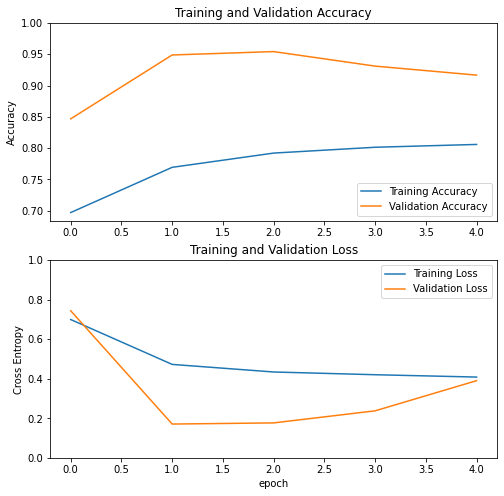

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Make some random predictions on the test data

In [29]:
test_image_names = ["1.jpg", "5.jpg"]
test_string_labels = ["dog", "cat"]
test_integer_labels = [1, 0]

test_df = pd.DataFrame({
    'image_name' : test_image_names,
    'string_label' : test_string_labels,
    'integer_label' : test_integer_labels
})

### Get test examples count

In [30]:
test_df.count()

image_name       2
string_label     2
integer_label    2
dtype: int64

### Look at the test dataframe head

In [31]:
test_df.head()

,image_name,string_label,integer_label
0,1.jpg,dog,1
1,5.jpg,cat,0


### Data Preprocessing

In [32]:
# Rescale all images
# Multiplying each value in the tensor by (1.0/255) is the same as dividing by 255
test_data_image_gen = ImageDataGenerator(rescale=1.0/255)

# Get the actual training data generator
test_generator = test_data_image_gen.flow_from_dataframe(
    test_df,                     # The dataframe containing filenames relative to "directory"
    directory = TEST_DATA_DIR,   # The directory in which the training images can be found
    x_col = "image_name",        # The column within the dataframe which is to be treated as the input
    y_col = "string_label",      # The column within the dataframe which is to be treated as the output
    target_size = (150, 150),    # Each image should be of size (150, 150)
    class_mode = "binary",       # We are dealing with a binary classification problem
    batch_size = 128             # Load images in batches of size 128
)

Found 2 validated image filenames belonging to 2 classes.


### Evaluate the Neural Network on the test data

In [33]:
full_model.evaluate(test_generator)

  ...
    to  
  ['...']
1/1 [==============================] - 0s 55ms/step - loss: 0.0201 - accuracy: 1.0000


[0.020101303234696388, 1.0]

### Get the predictions

In [34]:
model_predictions = full_model.predict(test_generator)

for idx, truth_label, model_label in zip(range(0, 2), test_integer_labels, model_predictions):
    print ("Image {}, Truth Label {}, Model Prediction {}".format(idx, truth_label, model_label))

Image 0, Truth Label 1, Model Prediction [0.0394051]
Image 1, Truth Label 0, Model Prediction [0.9999999]
